# `sdswrapper` tutorial

### A Python package for spatial data science workflows.

To install use: 
```bash
!pip install sdswrapper
```

Python packages:

In [1]:
import time
import rasterio

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor 

from pykrige.rk import RegressionKriging
from pykrige.ok import OrdinaryKriging

import sdswrapper as sds

Models instantiation:

In [2]:
model_list = [
    ('LinearRegression', LinearRegression()),
    ('RidgeRegression', Ridge()),
    ('LassoRegression', Lasso()),
    ('ElasticNetRegression', ElasticNet()),
    ('DecisionTreeRegression', DecisionTreeRegressor()),
    ('RandomForestRegression', RandomForestRegressor()),
    ('GradientBoostingRegression', GradientBoostingRegressor()),
    ('SupportVectorRegression', SVR()),
    ('KNearestNeighborsRegression', KNeighborsRegressor())
]

In [3]:
krige_models = list()

for model_name, model in model_list:

    if model_name == 'DecisionTreeRegression':

        continue

    krige_models.append(
        (
            'KrigingRegressionRF' + model_name,
            RegressionKriging(
                regression_model    = model,
                variogram_model     = 'linear',
                verbose             = False,
                nlags               = 10
            )
        )
    )

In [4]:
ordinary_kriging = sds.OrdinaryKrigingInterface()


model_list.append(
    ('OrdinaryKriging', ordinary_kriging)
)

In [5]:
model_list.extend(krige_models)

In [6]:
model_list

[('LinearRegression', LinearRegression()),
 ('RidgeRegression', Ridge()),
 ('LassoRegression', Lasso()),
 ('ElasticNetRegression', ElasticNet()),
 ('DecisionTreeRegression', DecisionTreeRegressor()),
 ('RandomForestRegression', RandomForestRegressor()),
 ('GradientBoostingRegression', GradientBoostingRegressor()),
 ('SupportVectorRegression', SVR()),
 ('KNearestNeighborsRegression', KNeighborsRegressor()),
 ('OrdinaryKriging', OrdinaryKrigingInterface()),
 ('KrigingRegressionRFLinearRegression',
  <pykrige.rk.RegressionKriging at 0x16b6a3c90>),
 ('KrigingRegressionRFRidgeRegression',
  <pykrige.rk.RegressionKriging at 0x16a64b050>),
 ('KrigingRegressionRFLassoRegression',
  <pykrige.rk.RegressionKriging at 0x16a1c79d0>),
 ('KrigingRegressionRFElasticNetRegression',
  <pykrige.rk.RegressionKriging at 0x16b3be5d0>),
 ('KrigingRegressionRFRandomForestRegression',
  <pykrige.rk.RegressionKriging at 0x168de6950>),
 ('KrigingRegressionRFGradientBoostingRegression',
  <pykrige.rk.RegressionKr

Study area polygon:

In [7]:
with rasterio.open(sds.EXAMPLE_PROBABILITY_SURFACE_FILEPATH) as src:

    reference_polygon_example = sds.SampleGenerator.get_polygon(src)

In [8]:
reference_polygon_example

[{'type': 'Polygon',
  'coordinates': [[(-81.57551, -57.133855000000004),
    (-81.57551, 12.991148657719998),
    (-34.03384085356, 12.991148657719998),
    (-34.03384085356, -57.133855000000004),
    (-81.57551, -57.133855000000004)]]}]

Sample Generator instantiation (for running the examples, here):

In [9]:
sg = sds.SampleGenerator(
    sample_file         = sds.EXAMPLE_SAMPLE_FILEPATH,
    features            = sds.EXAMPLE_FEATURES_FILEPATH,
    probability_surface = sds.EXAMPLE_PROBABILITY_SURFACE_FILEPATH,
    reference_polygon   = reference_polygon_example
)

Simulating presence sites sampling:

In [11]:
df_presence = sg.sample(100)
df_pseudoabsences = sg.sample(50, pseudoabsences=True)

Simulating (pseudo)absences sites sampling:

In [12]:
df_presence['occ'] = 1
df_pseudoabsences['occ'] = 0

Presence + (pseudo)absences dataset:

In [13]:
dataset = pd.concat([df_presence, df_pseudoabsences], axis=0)

Visual checking:

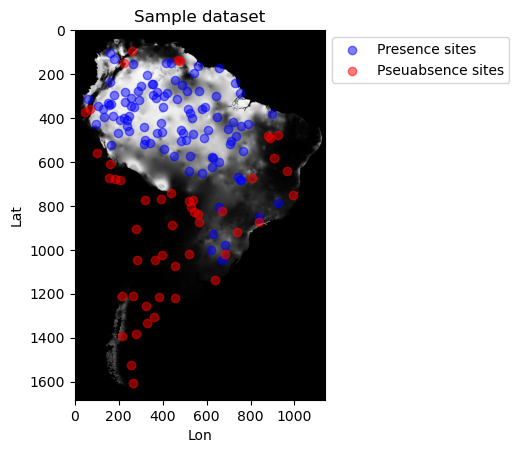

In [14]:
plt.imshow(sg.probability_surface, cmap='gray')

plt.scatter(
    df_presence['lon'], 
    df_presence['lat'],
    color = 'blue',
    alpha = 0.5, 
    label = 'Presence sites'
)

plt.scatter(
    df_pseudoabsences['lon'], 
    df_pseudoabsences['lat'],
    color = 'red',
    alpha = 0.5,
    label = 'Pseuabsence sites'
)

plt.title('Sample dataset')
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.legend(bbox_to_anchor=(1., 1.), loc='upper left')

Simple simulation of abundance:

In [15]:
def gaussian_function(df, mu1=25, sigma1=2, mu2=2000, sigma2=500):
    """
    Calcula uma função gaussiana combinando as colunas 'wc2.1_2.5m_bio_1' e 'wc2.1_2.5m_bio_12' do DataFrame.
    Os parâmetros mu1, sigma1, mu2, sigma2 podem ser ajustados conforme necessário.
    """
    x1 = df['wc2.1_2.5m_bio_1']
    x2 = df['wc2.1_2.5m_bio_12']

    gauss1 = np.exp(-0.5 * ((x1 - mu1) / sigma1) ** 2)

    gauss2 = np.exp(-0.5 * ((x2 - mu2) / sigma2) ** 2)

    return gauss1 * gauss2



K = 1000 # carryng capacity

dataset['abundance'] = np.round(gaussian_function(dataset) * K, 1)

Some adjustings, preventing overflow errors (potentially comming from .tif files):

In [16]:
# tratando os valores excessivamente baixos no .tiff (pois costuma levar a overflow).

dataset = dataset.map(
    lambda x: -999.0 if x < -1.0 else x
)

In [17]:
dataset['wc2.1_2.5m_bio_1'] = dataset['wc2.1_2.5m_bio_1'].round(1)
dataset['wc2.1_2.5m_bio_12'] = dataset['wc2.1_2.5m_bio_12'].round(1)

Final dataset inspection:

In [18]:
dataset

,lat,lon,wc2.1_2.5m_bio_1,wc2.1_2.5m_bio_12,occ,abundance
0,540.0,408.0,26.0,1897.0,1,865.2
1,249.0,488.0,27.1,1817.0,1,535.8
2,380.0,897.0,26.9,2012.0,1,641.5
3,202.0,329.0,27.4,2824.0,1,123.9
4,1047.0,672.0,18.3,1539.0,1,2.4
...,...,...,...,...,...,...
45,95.0,262.0,13.2,1005.0,0,0.0
46,1047.0,365.0,17.1,426.0,0,0.0
47,149.0,222.0,9.0,2044.0,0,0.0
48,493.0,888.0,25.4,1124.0,0,211.3


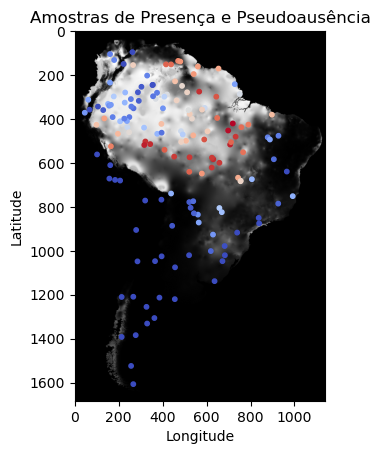

In [19]:
plt.imshow(sg.probability_surface, cmap='gray')

plt.scatter(
    dataset['lon'],
    dataset['lat'],
    c = dataset['abundance'],
    cmap = 'coolwarm',
    s = 10
)
plt.title('Amostras de Presença e Pseudoausência')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Spatial DS Wrapper - fitting all the models from `model_list`:

In [22]:
sds_wrapper = sds.Wrapper(
    model_list              = model_list,
    dataset                 = dataset,
    X_column_names          = ['lat', 'lon'],
    P_column_names          = ['wc2.1_2.5m_bio_1', 'wc2.1_2.5m_bio_12'],
    y_column_name           = 'abundance',
    projections_folder      = '/', # path to a folder dedicated to saving the projections
    k                       = 5,
    gridsearch_parameters   = None
)

In [23]:
output = sds_wrapper.fit()

/Users/drt67700/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.292e+04, tolerance: 1.483e+03
  model = cd_fast.enet_coordinate_descent(


Inspecting outputs:

In [24]:
df_output = pd.DataFrame(output).sort_values(by='model_metrics_mean', ascending=True)

In [25]:
df_output

,sample_size,name,model_type,model_metrics_mean,model_metrics_std,trained_model
15,150,KrigingRegressionRFGradientBoostingRegression,KR,79.676280,48.402872,<pykrige.rk.RegressionKriging object at 0x16b1...
6,150,GradientBoostingRegression,SK,80.924654,48.527312,([DecisionTreeRegressor(criterion='friedman_ms...
14,150,KrigingRegressionRFRandomForestRegression,KR,88.197981,69.810627,<pykrige.rk.RegressionKriging object at 0x168d...
8,150,KNearestNeighborsRegression,SK,93.371922,70.167314,KNeighborsRegressor()
5,150,RandomForestRegression,SK,98.086362,79.815144,"(DecisionTreeRegressor(max_features=1.0, rando..."
4,150,DecisionTreeRegression,SK,111.456711,88.681143,DecisionTreeRegressor()
17,150,KrigingRegressionRFKNearestNeighborsRegression,KR,210.690227,37.579551,<pykrige.rk.RegressionKriging object at 0x16b3...
16,150,KrigingRegressionRFSupportVectorRegression,KR,328.989198,163.213342,<pykrige.rk.RegressionKriging object at 0x1069...
3,150,ElasticNetRegression,SK,334.435742,135.593421,ElasticNet()
7,150,SupportVectorRegression,SK,342.146026,151.805686,SVR()


Building projections for the whole South America area:

`get_full_data`, from `SampleGenerator` class, is a helper to extract whole spatial data layer in a `pandas` `DataFrame` data structure.

In [26]:
df_full_data = sg.get_full_data()

In [28]:
df_full_data = df_full_data.map(
    lambda x: -999.0 if x < -1.0 else x
)

df_full_data['wc2.1_2.5m_bio_1'] = df_full_data['wc2.1_2.5m_bio_1'].round(1)
df_full_data['wc2.1_2.5m_bio_12'] = df_full_data['wc2.1_2.5m_bio_12'].round(1)

In [29]:
df_full_data

,lon,lat,wc2.1_2.5m_bio_1,wc2.1_2.5m_bio_12
0,0,0,-999.0,-999.0
1,0,1,-999.0,-999.0
2,0,2,-999.0,-999.0
3,0,3,-999.0,-999.0
4,0,4,-999.0,-999.0
...,...,...,...,...
1923123,1141,1679,-999.0,-999.0
1923124,1141,1680,-999.0,-999.0
1923125,1141,1681,-999.0,-999.0
1923126,1141,1682,-999.0,-999.0


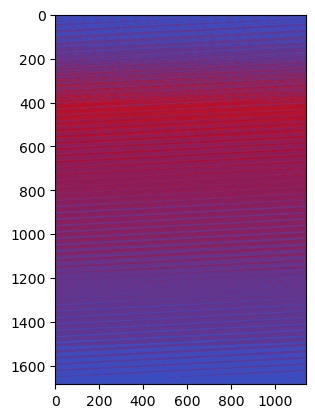

In [34]:
xpto = df_full_data['wc2.1_2.5m_bio_1'].values.reshape(sg.features[0]['raster'].shape)

plt.imshow(xpto, cmap='coolwarm')

Choosing a model (`model_id`) from the outputs (`df_output`) and computing model predictions:

In [30]:
model_id = 14

print('Model:', output[model_id]['name'])

prediction = sds_wrapper.predict(
    trained_model   = output[model_id]['trained_model'],
    X               = df_full_data[['lon', 'lat']],
    p               = df_full_data[['wc2.1_2.5m_bio_1', 'wc2.1_2.5m_bio_12']],
    shape           = sg.features[0]['raster'].shape
)

Model: KrigingRegressionRFRandomForestRegression


Plotting output:

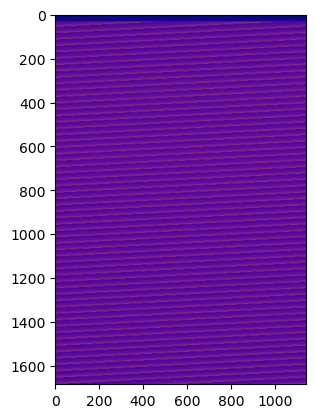

In [31]:
plt.imshow(prediction, cmap='plasma')

Computing model predictio scores:

In [ ]:
sds_wrapper.score(
    np.where(np.isnan(prediction), -1, prediction),
    np.where(np.isnan(sg.y), -1, sg.y),
)

In [ ]:
prediction = np.where(np.isnan(sg.y), np.nan, prediction)

In [ ]:
fig = plt.figure(figsize=(15, 5))

# Plotando o mapa observado
ax1 = plt.subplot(1, 2, 1)
plt.imshow(sg.y, cmap='coolwarm', vmin=0, vmax=1000)
plt.colorbar()
plt.title('Observed', fontsize=16)

# Adicionando os pontos do dataset
plt.scatter(dataset['coordenada_X'], dataset['coordenada_Y'], 
            c='red', s=10, label='Dataset Points')
plt.legend()

# Plotando o mapa previsto
ax2 = plt.subplot(1, 2, 2)
plt.imshow(prediction, origin='lower', cmap='coolwarm', vmin=0, vmax=1000)
plt.colorbar()
plt.gca().invert_yaxis()
plt.title('Predicted', fontsize=16)

plt.tight_layout()

In [ ]:
plt.imshow( (prediction - sg.y), cmap='coolwarm', interpolation='nearest', vmin=-1000, vmax=1000)
plt.colorbar()
plt.title('Error in Predicted Y')

Gráfico do Wrapper:

In [ ]:
df_output['prediction']  = df_output['trained_model'].apply(lambda x: sds_wrapper.predict(
    trained_model = x,
    X = df_full_data[['coordenada_X', 'coordenada_Y']],
    p = df_full_data[['p_1', 'p_2']],
    shape = sg.y.shape
))

In [ ]:
df_output['prediction']  = df_output['prediction'].apply(lambda x: sds_wrapper.mask(x, sg.y))

In [ ]:
sds_wrapper.plot(df_output, reference_data = sg.y, best = True)

In [ ]:
# End #